In [1]:
using LinearAlgebra
using DynamicPolynomials
using SpecialFunctions
using HomotopyContinuation
using PyPlot


According to Section *State-transfer in linear networks* of [Kurt Jacobs *et al* 2016 EPL **114** 40007](https://iopscience.iop.org/article/10.1209/0295-5075/114/40007#epl17883s5), the equation of the motion for joint second moments
$$
    C = \langle {\bf v}^t {\bf v} \rangle 
    = \begin{pmatrix}
        \langle a^2 \rangle & \langle  a a^{\dagger} \rangle & \langle ab \rangle & \langle ab^{\dagger} \rangle \\
        \langle  a^\dagger a \rangle & \langle a^{\dagger} a^{\dagger} \rangle & \langle a^{\dagger} b \rangle & \langle a^{\dagger} b^{\dagger} \rangle \\
        \langle ab \rangle & \langle a^{\dagger} b \rangle & \langle b^2 \rangle & \langle b b^{\dagger} \rangle \\
        \langle a b^{\dagger} \rangle & \langle a^{\dagger} b^{\dagger} \rangle & \langle b^{\dagger} b \rangle & \langle b^{\dagger} b^{\dagger} \rangle 
     \end{pmatrix}
$$
is given by
$$
    \partial_t C = AC + CA^T.
$$

$$
    \partial_t vec(C) = (A ⊗ 1 + 1 ⊗ A) vec(C) 
$$

In [2]:
# the initial condition
vecC₀ = [0; 1; 0; 0;   2; 0; 0; 0;   0; 0; 0; 0;   0; 0; 1; 0];

In [3]:
# systems parameters
ω = 1 #1 // 1
g = 1 #1 // 1



function A(λ₁)
    # The matrix in the equation of motion for C
    
    im * [ω    0      -λ₁*g  -λ₁*g
          0    -ω     λ₁*g  λ₁*g
         -λ₁*g -λ₁*g  ω      0
          λ₁*g λ₁*g   0     -ω]
end

A (generic function with 1 method)

## Utilities

In [4]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function scaling_poly(p::Polynomial)
    #=
    Estimate the scaling factor for the variables of a polynomial to make TSSOS computations numerically stable 
    =#
    
    # Simple linear gergression 
    linreg(x, y) = hcat(fill!(similar(x), 1), x) \ y
    
    # Get the scaling 
    scaling = linreg(
        [degree(t) for t in terms(p)], 
        log.(abs.(coefficients(p)))
    )[2]
            
    exp(abs(scaling))
end

"""
The generator of motion
"""
function 𝓐(x)
    a = A(x)
    
    𝓘 = Matrix(I, size(a))
    
    kron(a, 𝓘) + kron(𝓘, a)
end

function propagate(Δt::Real, λ::AbstractArray)   
    #=
    Solve the equation of motion
    =#
    prod(exp(Δt * 𝓐(λ₁)) for λ₁ in λ) * vecC₀
end

function get_exact_obj(Δt::Real, λ::AbstractArray) 
    real(propagate(Δt, λ)[2])
end

get_exact_obj (generic function with 1 method)

## Chebyshve polynomial approximation for $\exp_p(\Delta t \Omega)$

In [5]:
"""
Chebyshev approximation for exp(Δt Ω)
"""
function exp_chebyshev(Δt::Real, Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, Δt) * Tₙ₋₁ + 2 * besselj(1, Δt) * Tₙ
    
    # To guarantee the convergence of the series 
    @assert order > Δt + 2
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series += 2 * besselj(n, Δt) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

### Fid the critical points of the polynomial approximation for the objective function $\langle  a^\dagger a \rangle$  for a given number of time slices $m$ and scaling $\kappa$ 

In [6]:
"""
Get the minimum of the exact objective function

m - number of time slices
κ - scaling 
"""
function min_obj(m::Integer, κ::Real)
    
    @polyvar λ[1:m]
    
    T = 0.15
    
    Δt = T / m
    
    # Construct the polynomial approximation for the objective function 
    obj_propagator = prod(exp_chebyshev(Δt * κ, 𝓐(λ₁) / κ, 10) for λ₁ in λ);
    obj = (obj_propagator * vecC₀)[2]
    obj = real_poly(obj);
    
    # Find the critical points  
    result = solve(differentiate.(obj, λ))
    critical_points = real_solutions(result)
    
    # Get the exact values for the exact objective function for the found critical points  
    val_obj = get_exact_obj.(Δt, critical_points)
    
    val_obj[argmin(val_obj)]
end

min_obj

### Scaling values to scan

In [7]:
Κ = range(25, 40, 5)

25.0:3.75:40.0

## Try 2 time slices 

In [8]:
min_obj_2time_slices = min_obj.(2, Κ)

Tracking 85 paths... 100%|██████████████████████████████| Time: 0:00:43
  # paths tracked:                  85
  # non-singular solutions (real):  57 (15)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         57 (15)


5-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0

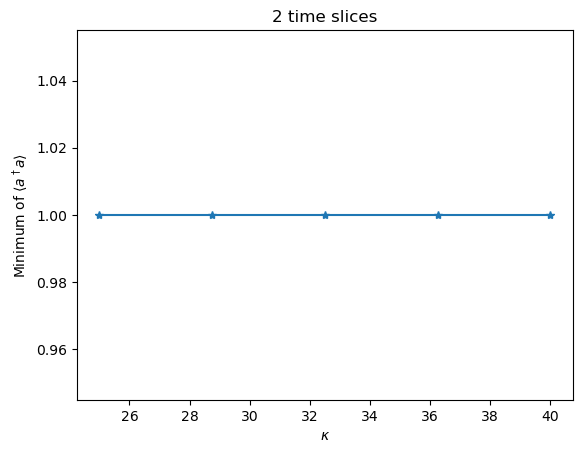

In [9]:
title("2 time slices")
plot(Κ, min_obj_2time_slices, "*-")
xlabel(L"\kappa")
ylabel("Minimum of " * L"\langle  a^\dagger a \rangle")
show()

## Try 3 time slices 

In [10]:
min_obj_3time_slices = min_obj.(3, Κ)

Tracking 1783 paths... 100%|████████████████████████████| Time: 0:00:02
  # paths tracked:                  1783
  # non-singular solutions (real):  91 (35)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         91 (35)


5-element Vector{Float64}:
 0.009593317681918734
 0.008880146692916924
 0.009722263028265843
 0.012263192240794751
 0.016704353334660027

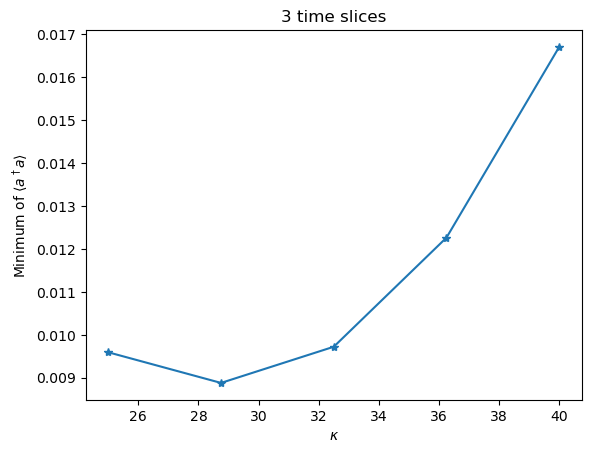

In [11]:
title("3 time slices")
plot(Κ, min_obj_3time_slices, "*-")
xlabel(L"\kappa")
ylabel("Minimum of " * L"\langle  a^\dagger a \rangle")
show()

In [12]:
0.15 / (2. * π)

0.0238732414637843

## Repeat of 3 time slices 

In [13]:
min_obj_3time_slices = min_obj.(3, Κ)

Tracking 1783 paths... 100%|████████████████████████████| Time: 0:00:02
  # paths tracked:                  1783
  # non-singular solutions (real):  96 (35)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         96 (35)


5-element Vector{Float64}:
 0.009593317681918734
 0.008880146692916924
 0.009722263028265843
 0.012263192240794751
 0.016704353334660027

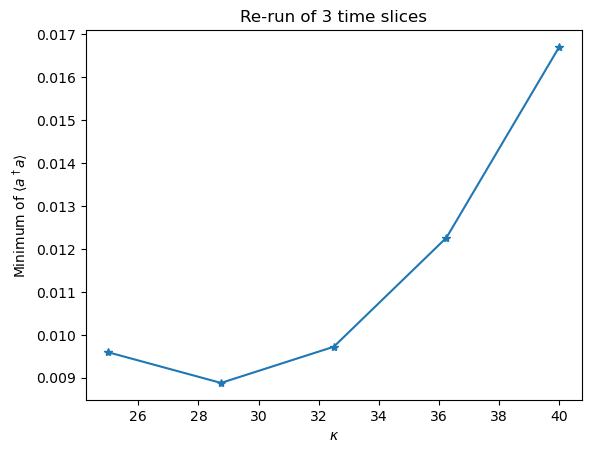

In [14]:
title("Re-run of 3 time slices")
plot(Κ, min_obj_3time_slices, "*-")
xlabel(L"\kappa")
ylabel("Minimum of " * L"\langle  a^\dagger a \rangle")
show()